In this notebook, I explore the story data and metadata.

In [1]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from wordcloud import WordCloud
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib notebook

In [2]:
data = pd.read_pickle('files/creep.pkl')

In [3]:
data.head(10)

,title,date,subgenre,rating,time,author,polarity,subjectivity
0,blood magic,2020-07-24,beings entities monsters creatures cryptids ...,8.15,8,Tobias Wade,0.046569,0.501569
1,a diner open 25 hours a day,2020-07-23,abductions kidnappings beings entities scien...,8.08,12,Christopher Maxim,0.033834,0.514034
2,a shattered life,2020-07-22,madness paranoia mental illness monsters crea...,9.10,14,Matt Dymerski,0.054970,0.531194
3,always be nice to your neighbors,2020-07-21,deaths murders disappearances,7.45,4,Christine Druga,0.020018,0.402989
4,vantablack a death metal cult,2020-07-20,rites rituals,7.63,13,Christopher Maxim,0.120475,0.501398
5,new england residents beware,2020-07-19,deaths murders disappearances locations site...,7.95,9,David Feuling,0.060248,0.450850
6,if you see this building your timeline might ...,2020-07-18,apocalyptic dystopian artifacts objects loca...,6.91,5,Christopher Maxim,0.122275,0.567651
7,the family spirit,2020-07-17,ghosts spirits,8.83,9,Tobias Wade,0.031499,0.501432
8,oranges,2020-07-16,beings entities demons possession strange u...,8.00,18,Matt Dymerski,-0.075987,0.544106
9,my dad keeps going out to the woods at night,2020-07-15,deaths murders disappearances ghosts spirits,8.02,6,Christopher Maxim,0.130168,0.509364


In [4]:
# Count by tokenizing
def count_words(word_string):
    word_list = nltk.word_tokenize(word_string)
    
    return len(word_list)

In [5]:
data['title_length'] = data['title'].apply(count_words)
data['subgenre_count'] = data['subgenre'].apply(count_words)

In [6]:
# remove common noise words
extras = ['like', 'just', 'said', 'im', 'didnt', 'dont', 'did', 'youre', 'youare', 'werent']
stop_words = text.ENGLISH_STOP_WORDS.union(extras)

In [7]:
stories = pd.read_pickle('files/corpus.pkl')

In [8]:
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(stories['story'])
dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
dtm.index = stories['title']
dtm = dtm.transpose()

In [9]:
del data_cv, stories, cv

In [10]:
data['num_words'] = dtm.sum().array

In [11]:
mat = dtm.to_numpy()
div = data['num_words'].to_numpy()
freqs = mat/div
del mat, div
data['mean_word_freq'] = freqs.sum(0)/(freqs!=0).sum(0)
del freqs

In [12]:
data['num_unique_words'] = np.count_nonzero((dtm.to_numpy()), axis=0)

In [13]:
data['unique_ratio'] = data['num_unique_words']/data['num_words']

In [14]:
data.corr().loc['rating']**2

rating              1.000000
time                0.057003
polarity            0.000193
subjectivity        0.000965
title_length        0.006230
subgenre_count      0.003101
num_words           0.006345
mean_word_freq      0.061400
num_unique_words    0.079219
unique_ratio        0.111508
Name: rating, dtype: float64

<IPython.core.display.Javascript object>


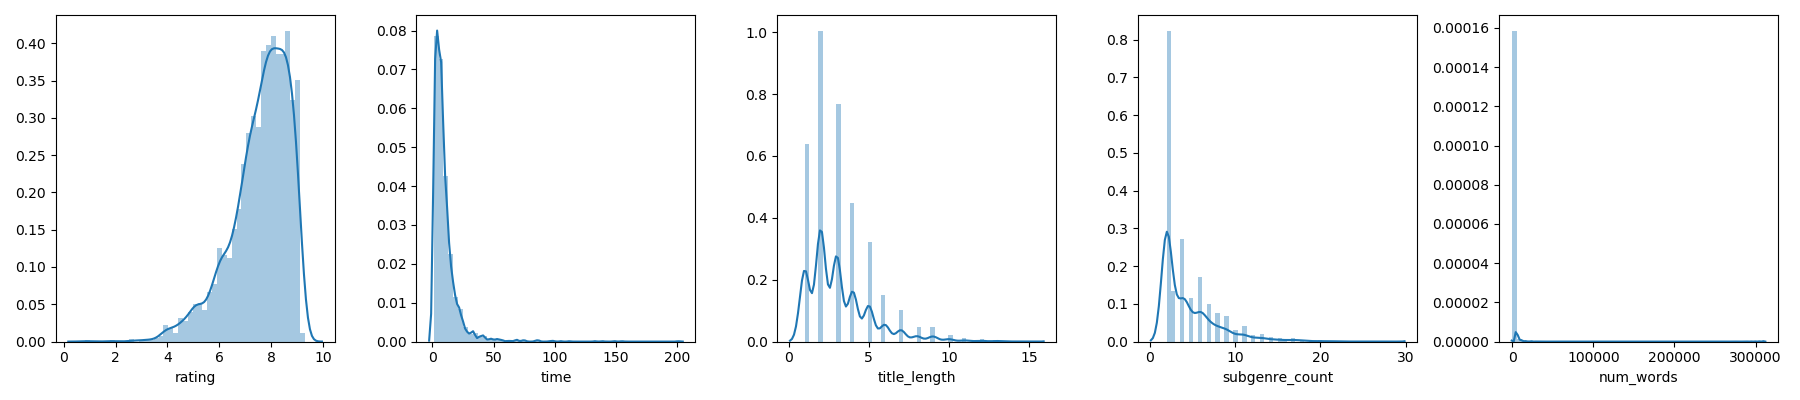

In [15]:
cols = ['rating', 'time', 'title_length', 'subgenre_count', 'num_words']

fig, axes = plt.subplots(1,5, figsize=(18,4))
for i, c in enumerate(cols):
    sns.distplot(data[c], ax=axes[i], axlabel=cols[i])
    
fig.tight_layout()

<IPython.core.display.Javascript object>


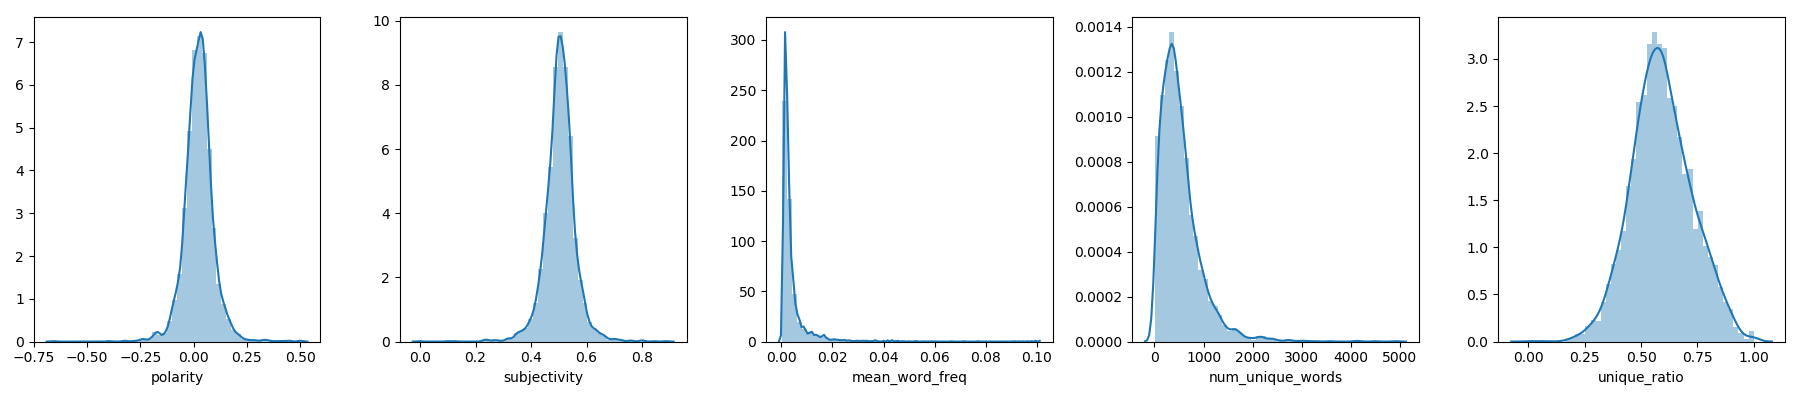

In [16]:
cols = ['polarity', 'subjectivity', 'mean_word_freq', 'num_unique_words', 'unique_ratio']

fig, axes = plt.subplots(1,5, figsize=(18,4))
for i, c in enumerate(cols):
    sns.distplot(data[c], ax=axes[i], axlabel=cols[i])
    
fig.tight_layout()

<IPython.core.display.Javascript object>


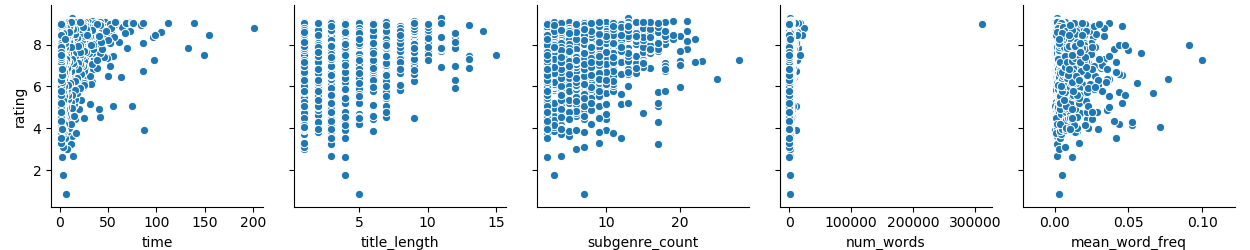

In [17]:
sns.pairplot(data, x_vars = ['time', 'title_length', 'subgenre_count', 'num_words', 'mean_word_freq'], y_vars=['rating'])

<IPython.core.display.Javascript object>


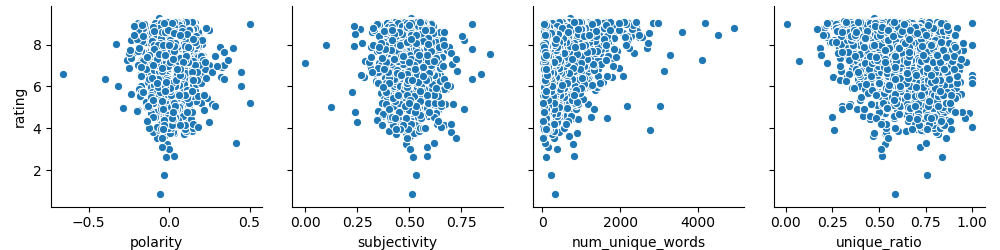

In [18]:
sns.pairplot(data, x_vars = ['polarity', 'subjectivity', 'num_unique_words', 'unique_ratio'], y_vars=['rating'])

In [19]:
sub_list = []

for s in data.subgenre:
    for word in nltk.word_tokenize(s):
        if word not in sub_list:
            sub_list.append(word)

In [20]:
def avg_subgenre_ratings(df, subs):
    ratings = []
    
    for sub in subs:
        temp = []
        
        for i,s in enumerate(df['subgenre']):
            if sub in s:
                temp.append(df.loc[i, 'rating'])
        
        ratings.append(np.mean(temp))
        
    return ratings        

In [21]:
rate = avg_subgenre_ratings(data, sub_list)

In [22]:
rate_frame = pd.DataFrame({'rating': rate}, index=sub_list).sort_values('rating', ascending=False)

<IPython.core.display.Javascript object>


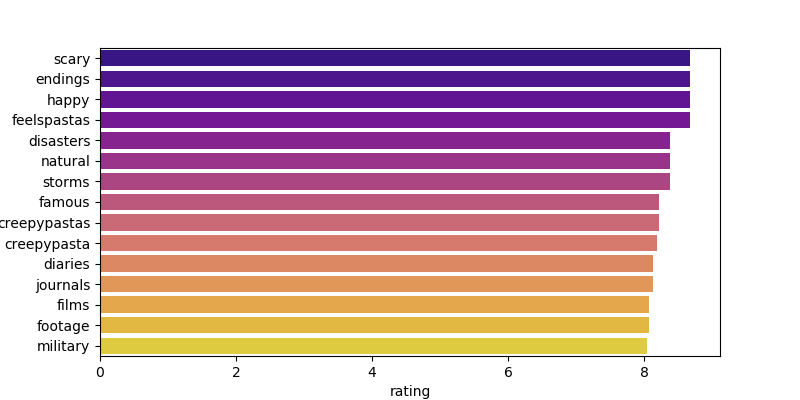

In [23]:
plt.figure(figsize=(8,4))
sns.barplot(rate_frame.rating[:15], rate_frame.index[:15], palette='plasma');

<IPython.core.display.Javascript object>


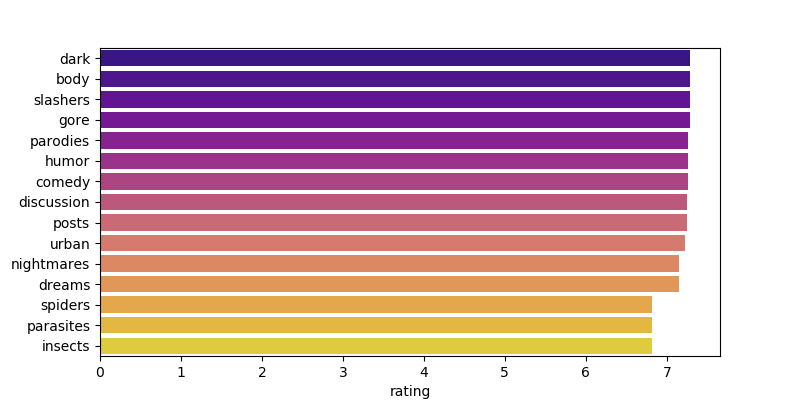

In [24]:
plt.figure(figsize=(8,4))
sns.barplot(rate_frame.rating[-15:], rate_frame.index[-15:], palette='plasma');

In [25]:
del rate_frame

In [26]:
def top_dict(df):
    top_words = {}
    cols = df.columns
    for i in range(df.shape[1]):
        t = df.iloc[:,i].sort_values(ascending=False).head(15)
        top_words[cols[i]] = list(zip(t.index, t.values))
    
    return top_words

In [27]:
words = top_dict(dtm)

In [28]:
top = list(data.sort_values(by='rating', ascending=False).head(10)['title'])
bot = list(data.sort_values(by='rating').head(10)['title'])

In [29]:
def plot_top_words(title_list, word_dict):

    plt.rcParams['figure.figsize'] = [16, 6]
    wc = WordCloud()
    for i,s in enumerate(title_list):
        wc.generate_from_frequencies(dict(word_dict[s]))
        plt.subplot(3,4,i+1)
        plt.imshow(wc)
        plt.axis('off')
        plt.title(s)



<IPython.core.display.Javascript object>


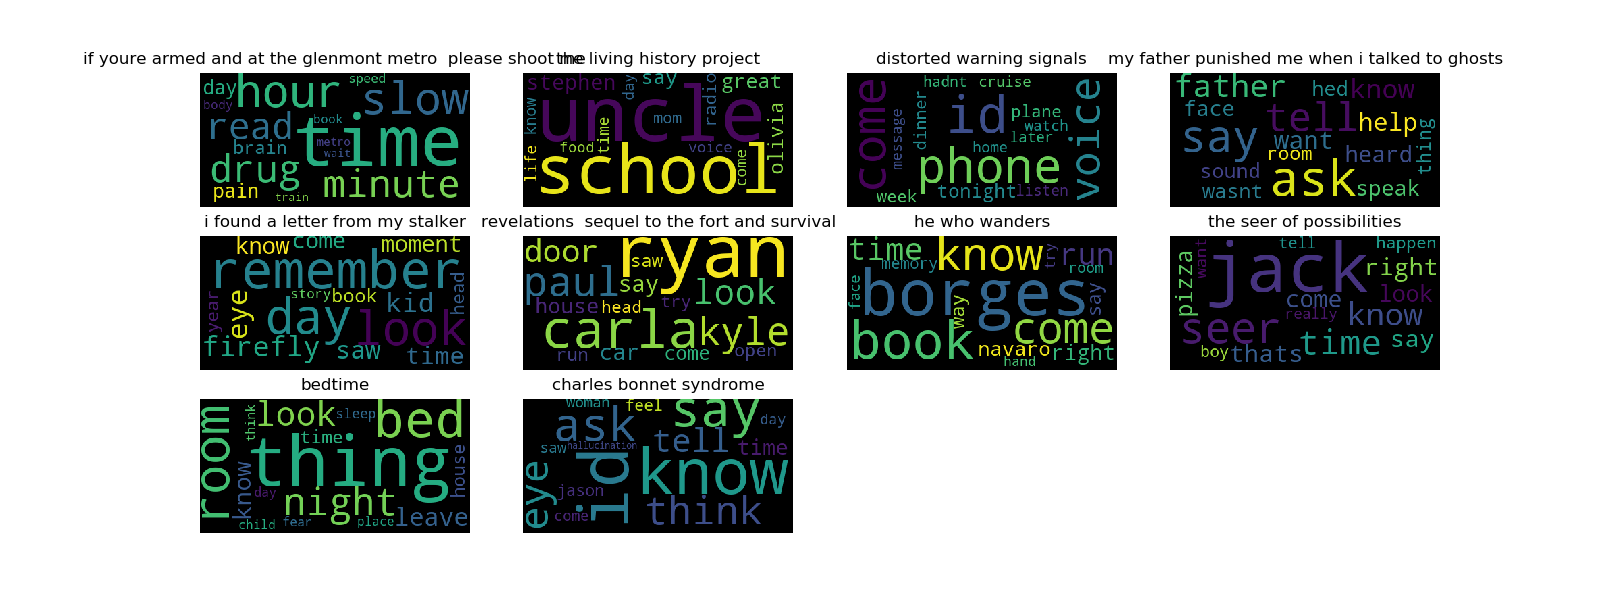

In [30]:
plot_top_words(top,words)

<IPython.core.display.Javascript object>


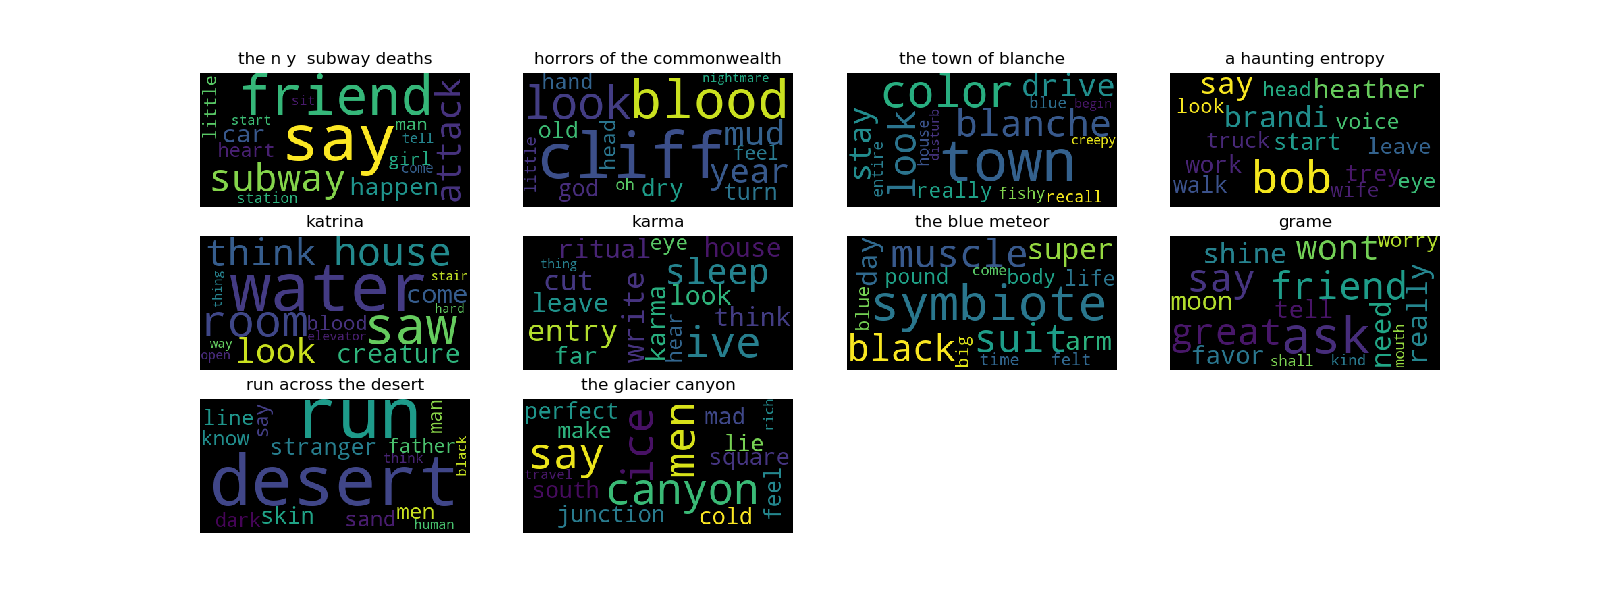

In [31]:
plot_top_words(bot,words)

In [32]:
data.to_pickle('files/creep.pkl')